# Import necessary modules

In [32]:
!pip install -U -q neurograd["all"]

import neurograd as ng
import os
import numpy as np
import gzip
import urllib.request

try:
    import cupy as cp
except ImportError:
    print("[INFO] CuPy not found – using NumPy (CPU) for the demo.")
    import numpy as cp

from matplotlib import pyplot as plt
import random

# Prepare Lecun's MNIST dataset

In [10]:
# -------------------------------------------------
# MNIST → CuPy (or NumPy) with one‑hot labels,
# downloading directly from the Google‑Cloud mirror.

MIRROR_URL = "https://storage.googleapis.com/cvdf-datasets/mnist/"
FILES = {
    "train_images": "train-images-idx3-ubyte.gz",
    "train_labels": "train-labels-idx1-ubyte.gz",
    "test_images":  "t10k-images-idx3-ubyte.gz",
    "test_labels":  "t10k-labels-idx1-ubyte.gz",
}
NUM_CLASSES = 10
IMG_SHAPE   = (28, 28)   # original MNIST size
PADDED_SHAPE = (32, 32)  # after padding (2‑pixel border each side)



def maybe_download(filename: str) -> str:
    """
    Download `filename` from the Google‑Cloud mirror if it does not already exist.
    Returns the local path to the file.
    """
    if not os.path.exists(filename):
        url = MIRROR_URL + filename
        print(f"[DOWNLOAD] {url}")
        urllib.request.urlretrieve(url, filename)
    else:
        print(f"[SKIP] {filename} already present.")
    return filename



def read_idx_gz(path: str, header_bytes: int) -> np.ndarray:
    """
    Read a gzipped IDX file and return the raw contents as a 1‑D uint8 NumPy array.
    `header_bytes` is the number of bytes to strip (magic number + dimensions).
    """
    with gzip.open(path, "rb") as f:
        buffer = f.read()
    return np.frombuffer(buffer, dtype=np.uint8)[header_bytes:]


# -------------------------------------------------
# Download + parse all four files
# -------------------------------------------------
train_images_path = maybe_download(FILES["train_images"])
train_labels_path = maybe_download(FILES["train_labels"])
test_images_path  = maybe_download(FILES["test_images"])
test_labels_path  = maybe_download(FILES["test_labels"])

train_images = read_idx_gz(train_images_path, header_bytes=16).reshape(-1, *IMG_SHAPE)
train_labels = read_idx_gz(train_labels_path, header_bytes=8)

test_images  = read_idx_gz(test_images_path,  header_bytes=16).reshape(-1, *IMG_SHAPE)
test_labels  = read_idx_gz(test_labels_path,  header_bytes=8)

# -------------------------------------------------
# Normalise, pad, add channel dimension, move to CuPy/NumPy
# -------------------------------------------------
def preprocess(images: np.ndarray) -> cp.ndarray:
    """
    * Convert uint8 → float32 and scale to [0,1]
    * Pad from 28×28 → 32×32 (2‑pixel zero border)
    * Add the channel dimension → (N,1,32,32)
    Returns a CuPy (or NumPy) array.
    """
    # 1️⃣ Normalise
    images = images.astype(np.float32) / 255.0

    # 2️⃣ Pad height & width (constant = 0)
    images = np.pad(images,
                    pad_width=((0, 0), (2, 2), (2, 2)),
                    mode="constant")

    # 3️⃣ Add channel axis
    images = images[:, None, :, :]    # (N, 1, 32, 32)

    # 4️⃣ Transfer to the backend (GPU if CuPy, else CPU)
    return cp.asarray(images)


X_train = preprocess(train_images)
X_test  = preprocess(test_images)

# -------------------------------------------------
# Convert integer labels → one‑hot vectors
# -------------------------------------------------
def one_hot(labels: cp.ndarray, num_classes: int = NUM_CLASSES) -> cp.ndarray:
    """
    `labels` is a CuPy/NumPy 1‑D integer array.
    Returns a (N, num_classes) float32 array where the column matching the label is 1.
    """
    # `cp.eye` creates an identity matrix (num_classes × num_classes).
    # Indexing that matrix with the label vector expands each label into a row.
    return cp.eye(num_classes, dtype=cp.float32)[labels]


# Move integer labels onto the same backend first
y_train = cp.asarray(train_labels, dtype=cp.int64)
y_test  = cp.asarray(test_labels,  dtype=cp.int64)

# One‑hot encode
y_train = one_hot(y_train)
y_test  = one_hot(y_test)

# -------------------------------------------------
# Quick sanity‑check (printing a few shapes / dtypes)
# -------------------------------------------------
print("\n=== Dataset summary ===")
print(f"X_train shape : {X_train.shape}   dtype: {X_train.dtype}")
print(f"y_train shape : {y_train.shape}   dtype: {y_train.dtype}")

print(f"X_test  shape : {X_test.shape}    dtype: {X_test.dtype}")
print(f"y_test shape : {y_test.shape}   dtype: {y_test.dtype}")

[SKIP] train-images-idx3-ubyte.gz already present.
[SKIP] train-labels-idx1-ubyte.gz already present.
[SKIP] t10k-images-idx3-ubyte.gz already present.
[SKIP] t10k-labels-idx1-ubyte.gz already present.

=== Dataset summary ===
X_train shape : (60000, 1, 32, 32)   dtype: float32
y_train shape : (60000, 10)   dtype: float32
X_test  shape : (10000, 1, 32, 32)    dtype: float32
y_test shape : (10000, 10)   dtype: float32


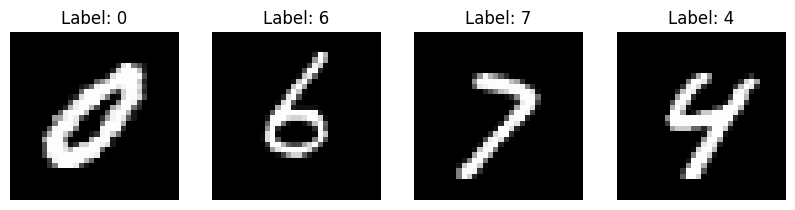

In [26]:
# Plot 4 random images

indices = range(len(X_train))
chosen = cp.random.choice(indices, 4)

plt.figure(figsize=(10, 7))
for i, idx in enumerate(chosen, 1):
  plt.subplot(1, 4, i)
  img = X_train[idx].reshape(32, 32).get()
  label = y_train[idx].argmax().squeeze().get()
  plt.axis("off")
  plt.imshow(img, cmap='gray')
  plt.title(f"Label: {label}")
plt.show()

In [30]:
from neurograd.utils.data import Dataset, DataLoader

train_dataset = Dataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = Dataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model architecture, optimizer and losses

In [77]:
from neurograd.nn.layers import Sequential, Conv2D, AveragePool2D, Flatten, Linear

model = Sequential(
    Conv2D(in_channels=1, out_channels=6, kernel_size=5, strides=1, activation="tanh"),
    AveragePool2D(pool_size=2, strides=2),
    Conv2D(in_channels=6, out_channels=16, kernel_size=5, strides=1, activation="tanh"),
    AveragePool2D(pool_size=2, strides=2),
    Flatten(),
    Linear(in_features=400, out_features=120, activation="tanh"),
    Linear(in_features=120, out_features=84, activation="tanh"),
    Linear(in_features=84, out_features=10, activation="softmax")
)

for name, param in model.named_parameters():
    print(name, param.shape)

layer_0.kernels (6, 1, 5, 5)
layer_0.bias (1, 6, 1, 1)
layer_2.kernels (16, 6, 5, 5)
layer_2.bias (1, 16, 1, 1)
layer_5.weight (400, 120)
layer_5.bias (120,)
layer_6.weight (120, 84)
layer_6.bias (84,)
layer_7.weight (84, 10)
layer_7.bias (10,)


In [78]:
from neurograd.optim import Adam
from neurograd.nn.losses import CategoricalCrossEntropy
from neurograd.nn.metrics import accuracy_score

optimizer = Adam(model.named_parameters(), lr=0.001)
loss_fn = CategoricalCrossEntropy()

# Training (mixed precision)

In [79]:
from tqdm.auto import tqdm
from neurograd.amp import GradScaler
scaler = GradScaler()

EPOCHS = 3
BATCH_SIZE = train_loader.batch_size


for epoch in range(1, EPOCHS + 1):

  print(f"Epoch: {epoch} / {EPOCHS}:")
  train_losses, train_acc = [], []
  test_losses, test_acc = [], []

  model.train()
  for (X_train, y_train) in tqdm(train_loader):
      with ng.autocast():
        y_pred = model(X_train)
        loss = loss_fn(y_train, y_pred)
        train_losses.append(loss.data)
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        acc = accuracy_score(y_train.argmax(axis=-1), y_pred.argmax(axis=-1))
        train_acc.append(acc)

  model.eval()
  for (X_test, y_test) in test_loader:
    with ng.autocast():
      y_pred = model(X_test)
      loss = loss_fn(y_test, y_pred)
      acc = accuracy_score(y_test.argmax(axis=-1), y_pred.argmax(axis=-1))
      test_losses.append(loss.data)
      test_acc.append(acc)

  # Convert lists to arrays before mean
  train_losses = cp.asarray(train_losses)
  train_acc = cp.asarray(train_acc)
  test_losses = cp.asarray(test_losses)
  test_acc = cp.asarray(test_acc)

  print(
      f"Train loss: {cp.mean(train_losses):.4f}, "
      f"Train acc: {cp.mean(train_acc):.4f}, "
      f"Test loss: {cp.mean(test_losses):.4f}, "
      f"Test acc: {cp.mean(test_acc):.4f}"
  )

Epoch: 1 / 3:


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 1.5844, Train acc: 0.9195, Test loss: 1.4150, Test acc: 0.9579
Epoch: 2 / 3:


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 1.4231, Train acc: 0.9591, Test loss: 1.3833, Test acc: 0.9656
Epoch: 3 / 3:


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 1.3959, Train acc: 0.9663, Test loss: 1.3700, Test acc: 0.9696


# Visualize model predictions

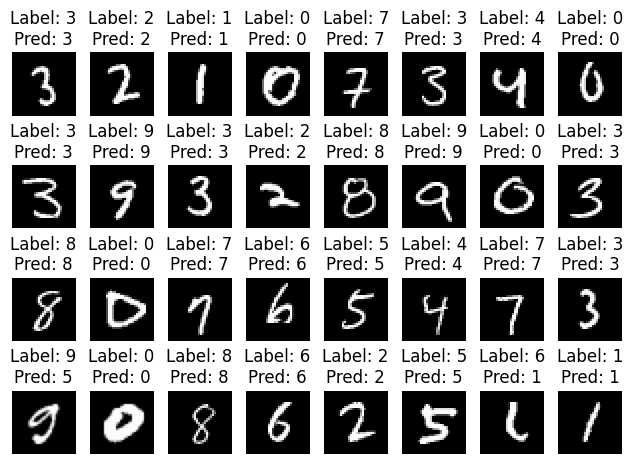

Guessed 30 / 32


In [105]:
X, y = random.choice(test_loader)
with ng.autocast():
    y_pred = model(X)

correct = 0
for idx in range(32):  # 4 rows * 8 cols = 32 images
    img = X[idx].data.reshape(32, 32).get()
    label = y[idx].data.argmax(-1).get()
    pred = y_pred[idx].data.argmax(-1).get()
    correct += label == pred

    plt.subplot(4, 8, idx + 1)  # subplot indices start at 1
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Label: {label}\nPred: {pred}")

plt.tight_layout()
plt.show()
print(f"Guessed {correct} / 32")